# Importing Libraries

In [89]:
import pandas as pd
import requests
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Loading MTA Data

In [39]:
# Create a function to apply a date to the MTA format URL for each .txt file

def url_creator(date):
    ''' 
    A function to apply a date to the MTA format URL for each .txt file
    '''
    return "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt".format(date)

In [40]:
# Create a function to return all saturdays 

def saturdays(start_date,end_date):
    ''' 
    A function to return all saturdays within two given dates
    '''
    dates = pd.date_range(start = start_date,end = end_date ,freq='W-SAT').strftime('%y%m%d').tolist()
    return dates

start_date = "2020-01-01"
end_date = "2021-01-01"

dates = saturdays(start_date, end_date)
print(dates)

['200104', '200111', '200118', '200125', '200201', '200208', '200215', '200222', '200229', '200307', '200314', '200321', '200328', '200404', '200411', '200418', '200425', '200502', '200509', '200516', '200523', '200530', '200606', '200613', '200620', '200627', '200704', '200711', '200718', '200725', '200801', '200808', '200815', '200822', '200829', '200905', '200912', '200919', '200926', '201003', '201010', '201017', '201024', '201031', '201107', '201114', '201121', '201128', '201205', '201212', '201219', '201226']


In [41]:
# creat a list of dataframe's to concat
list_df = []

# add all .txt files uplodaed for the given dates using the Saturday's function to a single dataframe

for date in dates:
    # creating a variable holding the basurl for a given date

    base_url = url_creator(date)
    # add and read each file to a dataframe and add it to the list to be concated
    
    df = pd.read_csv(str(base_url),parse_dates = [['DATE','TIME']],index_col = 'DATE_TIME')
    list_df.append(df)

In [42]:
# Consolidate all weekly dataframes into one data frame

consolidated_mta_data = pd.concat(list_df)

In [6]:
# Save data frame to local 

consolidated_mta_data.to_csv('consolidated_mta_data.csv')

NameError: name 'consolidated_mta_data' is not defined

In [7]:
# Load dataframe 

df = pd.read_csv("consolidated_mta_data.csv")

# Historical Weather in NYC

## 1) Loading Data

In [90]:
# add access token from the National Oceanic and Atmospheric Administration (NOAA)

token = 'ezGtBYtHkPAhGoeilnLTAThlLXnAQIiF'

In [91]:
# Add id for Central Park weather station

station_id = "GHCND:USW00094728"

In [92]:
# Create a list of variables to be included in the api call
# TMAX = max temperature measured in tenths of degrees C
# PRCP = total daily precipation (excludes snow), measured in tenths of milimeters
# SNOW = total daily snowfall, measured in millimeters

variables = ['TMAX', 'PRCP', 'SNOW'] 

In [93]:
# Create lists to store data

dates_tmax = []
dates_prcp = []
dates_snow = []
tmax = []
prcp = []
snow = []

In [94]:
# api call to retrieve 2020 data

# set the years to include 
start_year = 2020
end_year = 2020

for year in range(start_year,end_year+1):
    for var in variables:
        year = str(year)
        print("Working on year: {} and variable {}".format(year,var))

        # make the api call
        r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid='+var+'&limit=1000&stationid=' + station_id + '&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':token})
        # load the api response
        d = json.loads(r.text)
        
        
        try:
            # get all items in the response for the current variable in the loop
            save_metrics = [item for item in d['results'] if item['datatype']==var]
        
            if var == 'TMAX':
            
                # get the date field for each entry
                dates_tmax = [item['date'] for item in save_metrics]
            
                # get the corressponding date for each temperature entry
                tmax = [item['value'] for item in save_metrics]
        
            elif var == 'PRCP':
            
                # get the date field for each entry
                dates_prcp = [item['date'] for item in save_metrics]
            
                # get the corressponding date for each temperature entry
                prcp = [item['value'] for item in save_metrics]
        
            elif var == 'SNOW':
            
                # get the date field for each entry
                dates_snow = [item['date'] for item in save_metrics]
            
                # get the corressponding date for each temperature entry
                snow = [item['value'] for item in save_metrics]
            
        except:
            pass

Working on year: 2020 and variable TMAX
Working on year: 2020 and variable PRCP
Working on year: 2020 and variable SNOW


In [95]:
# Populating dataframes for each variable (date and variable value), converting dates to datetime

#Start with max temperature (convering to degrees fahrenheight from tenths of degrees C)

df_avg_temp = pd.DataFrame()
df_avg_temp['date'] = [datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in dates_tmax]
df_avg_temp['max_temp'] = [float(temp)/10.0 * 1.8 + 32 for temp in tmax]

# Working on Precipation (converting to inches from tenths of mm)

df_prcp = pd.DataFrame()
df_prcp['date'] = [datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in dates_prcp]
df_prcp['total_prcp'] = [float(p)/10 * 0.0393701 for p in prcp]


# Working on Snow (converting to inches from mm)

df_snow = pd.DataFrame()
df_snow['date'] = [datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in dates_snow]
df_snow['total_snow'] = [float(p)* 0.0393701 for p in snow]

In [96]:
# Merging all dataframes on date

# Merging max_temp and prcp
df_agg = pd.merge(left = df_avg_temp, right = df_prcp, left_on= 'date',right_on = 'date')

# Merging df_agg (includes max_temp and prcp) with snow
df_weather = pd.merge(left = df_agg, right = df_snow, left_on= 'date',right_on = 'date')

## 2) EDA on weather data

array([[<AxesSubplot:title={'center':'total_prcp'}>]], dtype=object)

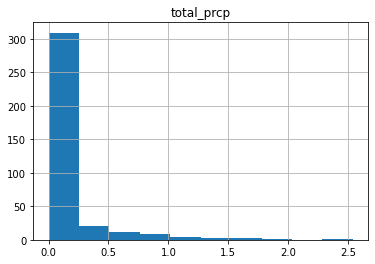

In [43]:
# temperature
df_weather.hist(column ="total_prcp")

array([[<AxesSubplot:title={'center':'total_snow'}>]], dtype=object)

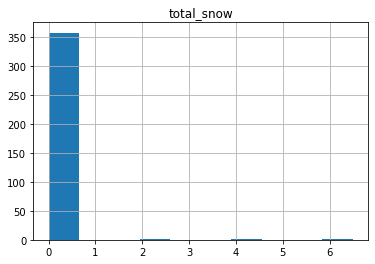

In [44]:
df_weather.hist(column ="total_snow")

array([[<AxesSubplot:title={'center':'max_temp'}>]], dtype=object)

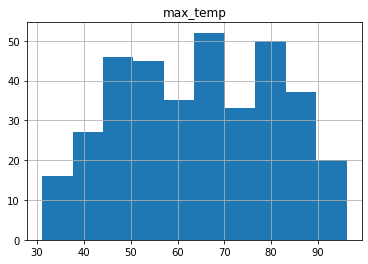

In [45]:
df_weather.hist(column="max_temp")

## 3) Initializing Variables

In [46]:
# Create a variable that groups all days that are "rainy" as a 1 if daily precipation is greater than 0.25 incehs and if not a 0

df_weather['rainy_day'] = np.where(df_weather['total_prcp']> 0.25, 1, 0)

In [47]:
# Create a variable that groups all days that are "snowy" as a 1 if daily snowfall is greater than 2.0 incehs and if not a 0

df_weather['snowy_day'] = np.where(df_weather['total_snow']> 2.0, 1, 0)

In [48]:
# Create a variable that groups all days that are "hot" as a 1 if daily max temp is greater than 80.0 degrees fahrenheit and if not a 0


df_weather['hot_day'] = np.where(df_weather['max_temp']> 80.0, 1, 0)

In [49]:
# Create a variable that groups all days that are "cold" as a 1 if daily max temp is less than 40 degrees fahrenheit and if not a 0


df_weather['cold_day'] = np.where(df_weather['max_temp']< 40.0, 1, 0)

## 4) Save to local

In [50]:
df_weather.to_csv('nyc_weather.csv')

# Cleaning MTAData

In [8]:
# Convert to date_time

In [9]:
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

In [10]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(20)

C/A  UNIT       SCP       STATION           DATE_TIME  ENTRIES
9732218  R514  R094  00-05-00  ASTORIA BLVD 2020-01-18 23:00:00        2
6885156  R110  R027  01-00-02       WALL ST 2020-12-15 07:00:00        2
6885154  R110  R027  01-00-02       WALL ST 2020-12-14 23:00:00        2
9732219  R514  R094  00-05-00  ASTORIA BLVD 2020-01-19 03:00:00        2
9732235  R514  R094  00-05-00  ASTORIA BLVD 2020-01-21 19:00:00        2
9732217  R514  R094  00-05-00  ASTORIA BLVD 2020-01-18 19:00:00        2
5977407  N701  R571  00-00-00   86 ST-2 AVE 2020-09-24 09:00:00        2
9732216  R514  R094  00-05-00  ASTORIA BLVD 2020-01-18 15:00:00        2
9732215  R514  R094  00-05-00  ASTORIA BLVD 2020-01-18 11:00:00        2
1745184  H009  R235  00-06-03    BEDFORD AV 2020-08-12 16:00:00        2
1745185  H009  R235  00-06-03    BEDFORD AV 2020-08-12 20:00:00        2
9732214  R514  R094  00-05-00  ASTORIA BLVD 2020-01-18 07:00:00        2
9732213  R514  R094  00-05-00  ASTORIA BLVD 2020-01-18 03:00:00        2
9732236  R514  R094  00-05-00  ASTORIA BLVD 2020-01-21 23:00:00        2
1745189  H009  R235  00-06-03    BEDFORD AV 2020-08-13 00:00:00        2
1745190  H009  R235  00-06-03    BEDFORD AV 2020-08-13 04:00:00        2
9732237  R514  R094  00-05-00  ASTORIA BLVD 2020-01-22 03:00:00        2
9732238  R514  R094  00-05-00  ASTORIA BLVD 2020-01-22 07:00:00        2
1634571  H001  R175  00-00-02          8 AV 2020-02-01 00:00:00        2
5473267  N532  R129  00-00-00     BERGEN ST 2020-08-31 17:00:00        2

In [11]:
# Get rid of the duplicate entry
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [12]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(20)

C/A  UNIT       SCP         STATION           DATE_TIME  ENTRIES
0        A002  R051  02-00-00           59 ST 2019-12-28 03:00:00        1
7213435  R138  R293  00-03-02  34 ST-PENN STA 2020-05-05 22:00:00        1
7213437  R138  R293  00-03-02  34 ST-PENN STA 2020-05-06 06:00:00        1
7213438  R138  R293  00-03-02  34 ST-PENN STA 2020-05-06 10:00:00        1
7213439  R138  R293  00-03-02  34 ST-PENN STA 2020-05-06 14:00:00        1
7213440  R138  R293  00-03-02  34 ST-PENN STA 2020-05-06 18:00:00        1
7213441  R138  R293  00-03-02  34 ST-PENN STA 2020-05-06 22:00:00        1
7213442  R138  R293  00-03-02  34 ST-PENN STA 2020-05-07 02:00:00        1
7213443  R138  R293  00-03-02  34 ST-PENN STA 2020-05-07 06:00:00        1
7213444  R138  R293  00-03-02  34 ST-PENN STA 2020-05-07 10:00:00        1
7213445  R138  R293  00-03-02  34 ST-PENN STA 2020-05-07 14:00:00        1
7213446  R138  R293  00-03-02  34 ST-PENN STA 2020-05-07 18:00:00        1
7213447  R138  R293  00-03-02  34 ST-PENN STA 2020-05-07 22:00:00        1
7213448  R138  R293  00-03-02  34 ST-PENN STA 2020-05-08 02:00:00        1
7213449  R138  R293  00-03-02  34 ST-PENN STA 2020-05-08 06:00:00        1
7213450  R138  R293  00-03-02  34 ST-PENN STA 2020-05-08 10:00:00        1
7213451  R138  R293  00-03-02  34 ST-PENN STA 2020-05-08 14:00:00        1
7213452  R138  R293  00-03-02  34 ST-PENN STA 2020-05-08 18:00:00        1
7213453  R138  R293  00-03-02  34 ST-PENN STA 2020-05-08 22:00:00        1
7213436  R138  R293  00-03-02  34 ST-PENN STA 2020-05-06 02:00:00        1

In [13]:
df.dtypes

DATE_TIME                                                               datetime64[ns]
C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
dtype: object

In [14]:
# create a date only variable (remove hours and minutes)

df['DATE'] = df['DATE_TIME'].dt.date
df.head()
df.dtypes

DATE_TIME                                                               datetime64[ns]
C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
DATE                                                                            object
dtype: object

### Back to cleaning MTA Data...

In [15]:
# Creating a dataframe grouping by day

turnstiles_daily = (df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [16]:
turnstiles_daily.head(10)

C/A  UNIT       SCP STATION        DATE  ENTRIES
0  A002  R051  02-00-00   59 ST  2019-12-28  7325143
1  A002  R051  02-00-00   59 ST  2019-12-29  7325774
2  A002  R051  02-00-00   59 ST  2019-12-30  7326944
3  A002  R051  02-00-00   59 ST  2019-12-31  7327981
4  A002  R051  02-00-00   59 ST  2020-01-01  7328499
5  A002  R051  02-00-00   59 ST  2020-01-02  7329882
6  A002  R051  02-00-00   59 ST  2020-01-03  7331169
7  A002  R051  02-00-00   59 ST  2020-01-04  7331951
8  A002  R051  02-00-00   59 ST  2020-01-05  7332543
9  A002  R051  02-00-00   59 ST  2020-01-06  7333879

In [17]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-17-3a945374269e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [18]:
# sanity check

turnstiles_daily.head()

C/A  UNIT       SCP STATION        DATE  ENTRIES   PREV_DATE  PREV_ENTRIES
0  A002  R051  02-00-00   59 ST  2019-12-28  7325143         NaN           NaN
1  A002  R051  02-00-00   59 ST  2019-12-29  7325774  2019-12-28     7325143.0
2  A002  R051  02-00-00   59 ST  2019-12-30  7326944  2019-12-29     7325774.0
3  A002  R051  02-00-00   59 ST  2019-12-31  7327981  2019-12-30     7326944.0
4  A002  R051  02-00-00   59 ST  2020-01-01  7328499  2019-12-31     7327981.0

In [19]:
# Drop the rows for the earliest date in the df

turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [20]:
turnstiles_daily.head()

C/A  UNIT       SCP STATION        DATE  ENTRIES   PREV_DATE  PREV_ENTRIES
1  A002  R051  02-00-00   59 ST  2019-12-29  7325774  2019-12-28     7325143.0
2  A002  R051  02-00-00   59 ST  2019-12-30  7326944  2019-12-29     7325774.0
3  A002  R051  02-00-00   59 ST  2019-12-31  7327981  2019-12-30     7326944.0
4  A002  R051  02-00-00   59 ST  2020-01-01  7328499  2019-12-31     7327981.0
5  A002  R051  02-00-00   59 ST  2020-01-02  7329882  2020-01-01     7328499.0

## Handling negative values

In [21]:
# Checking where previous entries are greater than current

turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

C/A  UNIT       SCP     STATION        DATE  ENTRIES   PREV_DATE  \
4040  A002  R051  02-06-00       59 ST  2020-02-13      889  2020-02-12   
4127  A002  R051  02-06-00       59 ST  2020-09-12    27005  2020-05-09   
5795  A006  R079  00-00-04  5 AV/59 ST  2020-04-13       22  2020-04-12   
6125  A006  R079  00-03-00  5 AV/59 ST  2020-03-10       60  2020-03-09   
9065  A007  R079  01-06-03  5 AV/59 ST  2020-04-07        4  2020-04-06   

      PREV_ENTRIES  
4040       82625.0  
4127       44341.0  
5795     7896791.0  
6125     9437429.0  
9065     7832194.0

In [22]:
# Let's see how many stations have this problem

(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A002   R051  02-06-00  59 ST                2
A006   R079  00-00-04  5 AV/59 ST           1
             00-03-00  5 AV/59 ST           1
A007   R079  01-06-03  5 AV/59 ST           1
A011   R080  01-03-00  57 ST-7 AV         363
                                         ... 
R728   R226  00-00-00  GUN HILL RD          1
             00-00-01  GUN HILL RD          1
R729   R292  00-00-01  BAYCHESTER AV        1
R730   R431  00-00-04  EASTCHSTER/DYRE    361
TRAM1  R468  00-00-01  RIT-MANHATTAN        1
Length: 649, dtype: int64

In [23]:
# Create a function to handles instances where counter is descending

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

22 7896791.0
60 9437429.0
4 7832194.0
9 1562921334.0
289 3055256.0
348 1237351900.0
459077 85175465.0
123 1630877.0
20 2642748.0
848 1180101.0
305 7251354.0
658 1203534.0
26 3963030.0
6 6777428.0
1066 1091335.0
408 4676418.0
12 1309708904.0
294 6612092.0
107 8235039.0
210 2427404.0
379 1208236.0
93 1178971.0
88 1197880.0
262182 6657224.0
5309717 100663522.0
2031759 368226.0
170526823 1802952.0
248 1264348.0
36 5675074.0
25 8800439.0
223936549 167098.0
1294 6496220.0
1560308511 6140951.0
393220 118199797.0
455 2822958.0
524338 67889725.0
372 4971113.0
86 8360145.0
475957878 7480530.0
544 475738131.0
2920 3117927.0
618862 2634131.0
230 955727806.0
17126295 19676957.0
5177693 17134751.0
15065838 17126282.0
25525735 15065804.0
12309516 25525671.0
1730 1455549.0
233 2297325.0
219 1875169.0
631046281 246545.0
112 631050303.0
606 8096346.0
1136721145 6439404.0
212 3145253.0
72 1100765.0
590069 1906617.0
91 4038371.0
172229024 8843948.0
97 3953593.0
20 2635368.0
95 3571824.0
157 3563454.0
144 

In [325]:
turnstiles_daily.head()

C/A  UNIT       SCP STATION        DATE  ENTRIES   PREV_DATE  \
1  A002  R051  02-00-00   59 ST  2019-12-29  7325774  2019-12-28   
2  A002  R051  02-00-00   59 ST  2019-12-30  7326944  2019-12-29   
3  A002  R051  02-00-00   59 ST  2019-12-31  7327981  2019-12-30   
4  A002  R051  02-00-00   59 ST  2020-01-01  7328499  2019-12-31   
5  A002  R051  02-00-00   59 ST  2020-01-02  7329882  2020-01-01   

   PREV_ENTRIES  DAILY_ENTRIES  
1     7325143.0          631.0  
2     7325774.0         1170.0  
3     7326944.0         1037.0  
4     7327981.0          518.0  
5     7328499.0         1383.0

# Merging Weather Dataset

In [113]:
# Converting turnstile daily "date" variable to be the same type as in the mta data 
turnstiles_daily['DATE'] = pd.to_datetime(turnstiles_daily['DATE'])
turnstiles_daily.dtypes

C/A                      object
UNIT                     object
SCP                      object
STATION                  object
DATE             datetime64[ns]
ENTRIES                   int64
PREV_DATE                object
PREV_ENTRIES            float64
DAILY_ENTRIES           float64
dtype: object

In [114]:
turnstiles_daily_weather = pd.merge(left = turnstiles_daily, right = df_weather, left_on = 'DATE', right_on = 'date')

# Analysis (Excludes Weather)

In [119]:
# Searching for outliers

C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DAILY_ENTRIES', ylabel='Density'>

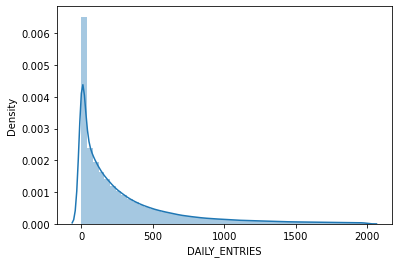

In [120]:
sns.distplot(turnstiles_daily['DAILY_ENTRIES']
             [turnstiles_daily['DAILY_ENTRIES'] < 10000])

In [121]:
# Given the limited number of entries above 2000 and those with less than 0 still we delete all below that number

In [122]:
turnstiles_daily.drop(turnstiles_daily[turnstiles_daily['DAILY_ENTRIES'] > 2000].index, inplace = True) 

### At the station level

In [123]:
# calculate daily entries by station
stations_daily = \
(turnstiles_daily.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum()
                 .reset_index())

stations_daily.head()

STATION       DATE  DAILY_ENTRIES
0    1 AV 2019-12-29         2933.0
1    1 AV 2019-12-30         6672.0
2    1 AV 2019-12-31         5699.0
3    1 AV 2020-01-01         7253.0
4    1 AV 2020-01-02         6003.0

### Calculating the top 10 stations

In [124]:
# top 10 stations by daily volume
# (sum across all days is a reasonable way to define this)
top10_stations = \
    (stations_daily.groupby(['STATION'])['DAILY_ENTRIES'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False) 
                   .STATION.head(10))

top10_stations.sort_values(ascending=False)

353     TIMES SQ-42 ST
233    GRD CNTRL-42 ST
226          FULTON ST
110              86 ST
85               59 ST
68     42 ST-PORT AUTH
61      34 ST-PENN STA
59     34 ST-HERALD SQ
46               23 ST
9               125 ST
Name: STATION, dtype: object

In [125]:
stations_daily_top10

STATION        DATE  DAILY_ENTRIES
3251            125 ST  2019-12-29        27088.0
3252            125 ST  2019-12-30        40012.0
3253            125 ST  2019-12-31        43837.0
3254            125 ST  2020-01-01        33529.0
3255            125 ST  2020-01-02        45638.0
...                ...         ...            ...
128108  TIMES SQ-42 ST  2020-12-21        18069.0
128109  TIMES SQ-42 ST  2020-12-22        18994.0
128110  TIMES SQ-42 ST  2020-12-23        19215.0
128111  TIMES SQ-42 ST  2020-12-24        13881.0
128112  TIMES SQ-42 ST  2020-12-25         7469.0

[3630 rows x 3 columns]

In [126]:
# next create a new df that filters the stations daily data down
# to the top 10 stations
stations_daily_top10 = \
    stations_daily[stations_daily['STATION'].isin(top10_stations)]
station_top10_totals = \
    stations_daily_top10.groupby(["STATION"])['DAILY_ENTRIES'].sum().reset_index().sort_values(by="DAILY_ENTRIES",ascending=False)  

In [127]:
station_top10_totals.head(10)

STATION  DAILY_ENTRIES
3   34 ST-PENN STA     11389339.0
6            86 ST      8022167.0
0           125 ST      8005955.0
1            23 ST      7652802.0
4  42 ST-PORT AUTH      7284479.0
7        FULTON ST      7037484.0
2  34 ST-HERALD SQ      7031880.0
8  GRD CNTRL-42 ST      6387444.0
5            59 ST      6045709.0
9   TIMES SQ-42 ST      5975873.0

<AxesSubplot:xlabel='DAILY_ENTRIES', ylabel='STATION'>

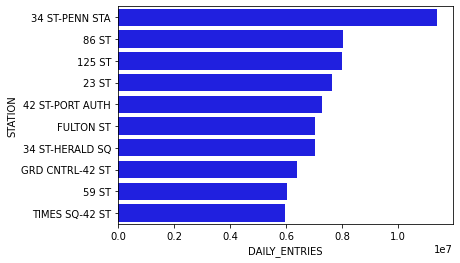

In [128]:
sns.barplot(x = 'DAILY_ENTRIES', y = "STATION",data=station_top10_totals,color="Blue")

In [129]:
# summing daily rides for the top 10 stations

daily_totals_top10 = \
    (stations_daily_top10.groupby(['DATE'])['DAILY_ENTRIES'].sum().reset_index())
daily_totals_top10

DATE  DAILY_ENTRIES
0   2019-12-29       351169.0
1   2019-12-30       473175.0
2   2019-12-31       461834.0
3   2020-01-01       365802.0
4   2020-01-02       452605.0
..         ...            ...
358 2020-12-21       245033.0
359 2020-12-22       251595.0
360 2020-12-23       252719.0
361 2020-12-24       184699.0
362 2020-12-25        63517.0

[363 rows x 2 columns]

### Time trends for top 10 stations

<AxesSubplot:xlabel='DATE', ylabel='DAILY_ENTRIES'>

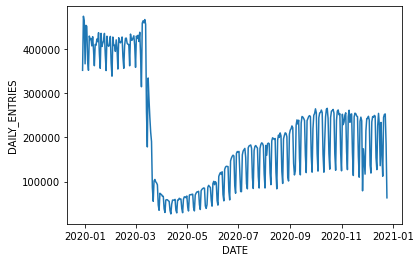

In [130]:
# top 10 stations aggregate trends
sns.lineplot(x = "DATE",y = "DAILY_ENTRIES",data=daily_totals_top10)


<AxesSubplot:xlabel='DATE', ylabel='DAILY_ENTRIES'>

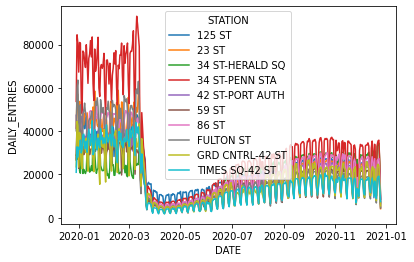

In [131]:
sns.lineplot(x = "DATE",y = "DAILY_ENTRIES",ci=None,hue='STATION',data=stations_daily_top10)

In [132]:
# The above graph suggests taht all of the top units followed similar patterns, 
# I create a mask to limit the dataset to be since march to reduce the y axis and more closely compare trends

In [133]:
# Converting to datetime to allow filtering on date

In [134]:
stations_daily_top10.dtypes

STATION                  object
DATE             datetime64[ns]
DAILY_ENTRIES           float64
dtype: object

In [135]:
stations_daily_top10['DATE'] = pd.to_datetime(stations_daily_top10['DATE'])

<ipython-input-135-1d48a5ab4600>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_daily_top10['DATE'] = pd.to_datetime(stations_daily_top10['DATE'])


In [136]:
stations_daily_top10.dtypes

STATION                  object
DATE             datetime64[ns]
DAILY_ENTRIES           float64
dtype: object

In [137]:
start_date = '03-15-2020'

In [138]:
mask = (stations_daily_top10['DATE'] > start_date)

In [139]:
stations_daily_top10_since_march = stations_daily_top10.loc[mask]

In [140]:
stations_daily_top10_since_march.head(10)

STATION       DATE  DAILY_ENTRIES
3329  125 ST 2020-03-16        32596.0
3330  125 ST 2020-03-17        33481.0
3331  125 ST 2020-03-18        31506.0
3332  125 ST 2020-03-19        28489.0
3333  125 ST 2020-03-20        27013.0
3334  125 ST 2020-03-21        15706.0
3335  125 ST 2020-03-22        10625.0
3336  125 ST 2020-03-23        15664.0
3337  125 ST 2020-03-24        16368.0
3338  125 ST 2020-03-25        15574.0

<AxesSubplot:xlabel='DATE', ylabel='DAILY_ENTRIES'>

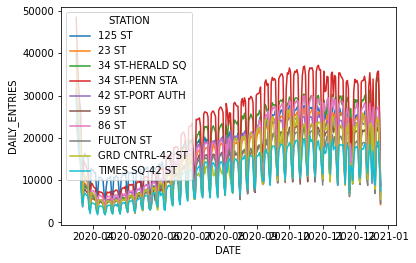

In [141]:
# Regraphing lineplot with dates reduced to since March
sns.lineplot(x = "DATE",y ="DAILY_ENTRIES",ci=None,hue='STATION',data=stations_daily_top10_since_march)

### Focussing on days of the weeek

In [142]:
# creating a column for day of week in top 10 dataframe

In [143]:
stations_daily_top10['day_of_week'] = stations_daily_top10['DATE'].dt.day_name()

<ipython-input-143-6a36ab525984>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_daily_top10['day_of_week'] = stations_daily_top10['DATE'].dt.day_name()


In [144]:
stations_daily_top10.head()

STATION       DATE  DAILY_ENTRIES day_of_week
3251  125 ST 2019-12-29        27088.0      Sunday
3252  125 ST 2019-12-30        40012.0      Monday
3253  125 ST 2019-12-31        43837.0     Tuesday
3254  125 ST 2020-01-01        33529.0   Wednesday
3255  125 ST 2020-01-02        45638.0    Thursday

In [145]:
totals_top_10_day_of_week = \
    (stations_daily_top10.groupby(['day_of_week'])['DAILY_ENTRIES']).sum().reset_index().sort_values(by='DAILY_ENTRIES',ascending=False)

In [146]:
totals_top_10_day_of_week.head(10)

day_of_week  DAILY_ENTRIES
5     Tuesday     12013899.0
6   Wednesday     11925389.0
0      Friday     11693876.0
1      Monday     11684626.0
4    Thursday     11669848.0
2    Saturday      8469056.0
3      Sunday      7376438.0

<AxesSubplot:xlabel='DAILY_ENTRIES', ylabel='day_of_week'>

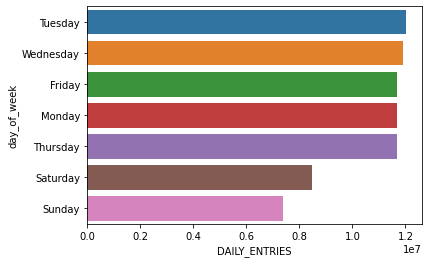

In [147]:
sns.barplot(x = 'DAILY_ENTRIES',y = "day_of_week",data=totals_top_10_day_of_week)